# Copia del lab 6


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Majix\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Note: you may need to restart the kernel to use updated packages.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


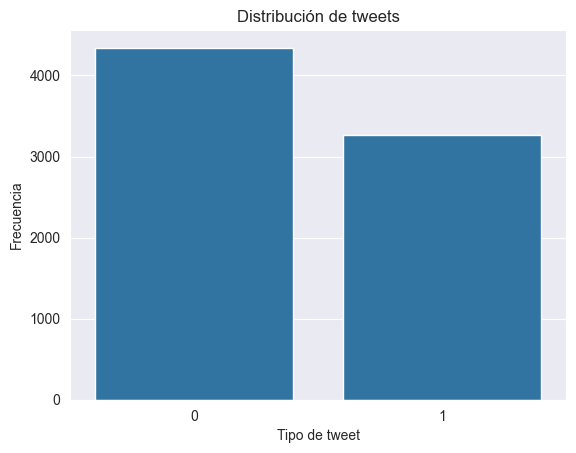

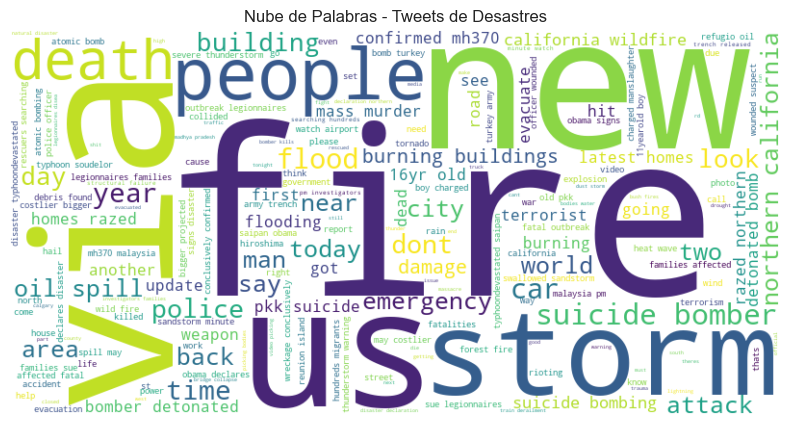

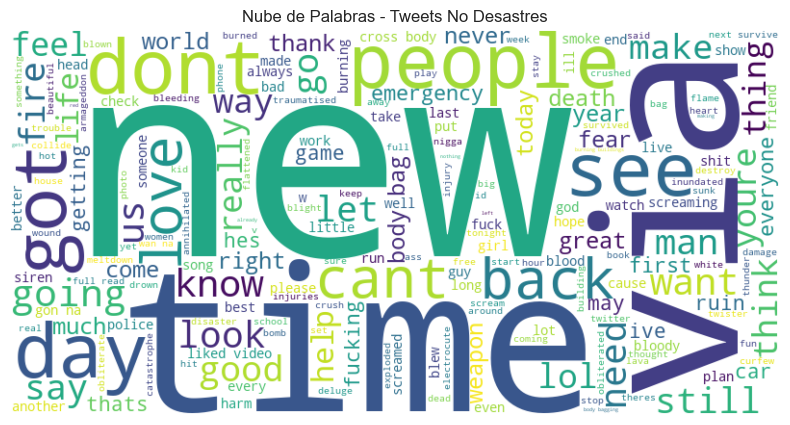

Palabras comunes más frecuentes en tweets de desastres y no desastres:
Palabra: fire, Frecuencia en Desastres: 179, Frecuencia en No Desastres: 70
Palabra: via, Frecuencia en Desastres: 121, Frecuencia en No Desastres: 99
Palabra: suicide, Frecuencia en Desastres: 110, Frecuencia en No Desastres: 6
Palabra: disaster, Frecuencia en Desastres: 110, Frecuencia en No Desastres: 36
Palabra: california, Frecuencia en Desastres: 107, Frecuencia en No Desastres: 5
Palabra: police, Frecuencia en Desastres: 106, Frecuencia en No Desastres: 34
Palabra: people, Frecuencia en Desastres: 104, Frecuencia en No Desastres: 91
Palabra: like, Frecuencia en Desastres: 92, Frecuencia en No Desastres: 253
Palabra: killed, Frecuencia en Desastres: 92, Frecuencia en No Desastres: 3
Palabra: fires, Frecuencia en Desastres: 84, Frecuencia en No Desastres: 16


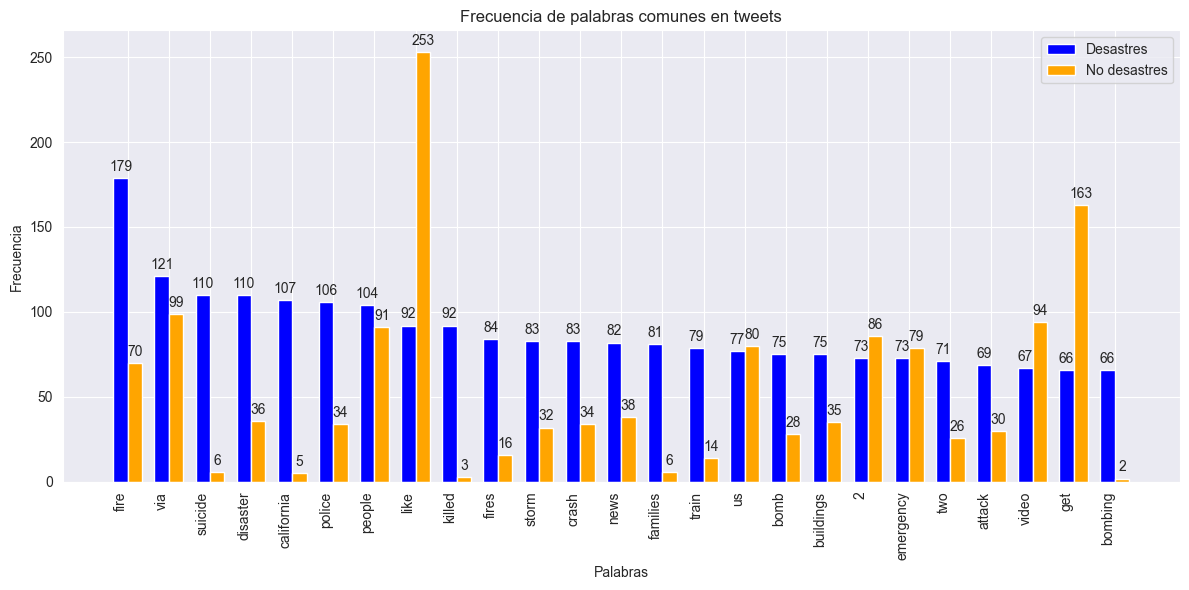

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       874
           1       0.75      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Confusion Matrix for Random Forest:
[[725 149]
 [204 445]]


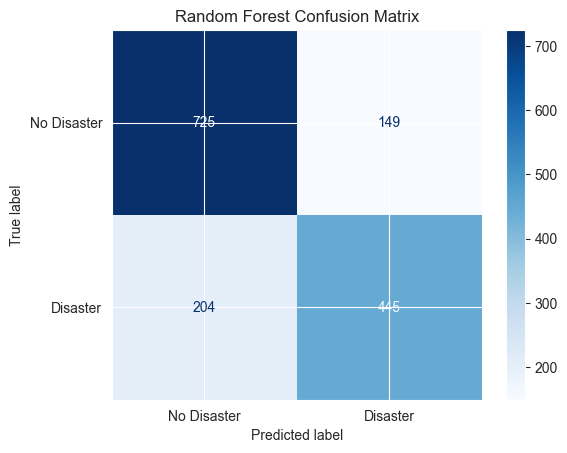

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       874
           1       0.81      0.59      0.68       649

    accuracy                           0.77      1523
   macro avg       0.78      0.74      0.75      1523
weighted avg       0.77      0.77      0.76      1523

Confusion Matrix for Random Forest:
[[785  89]
 [266 383]]


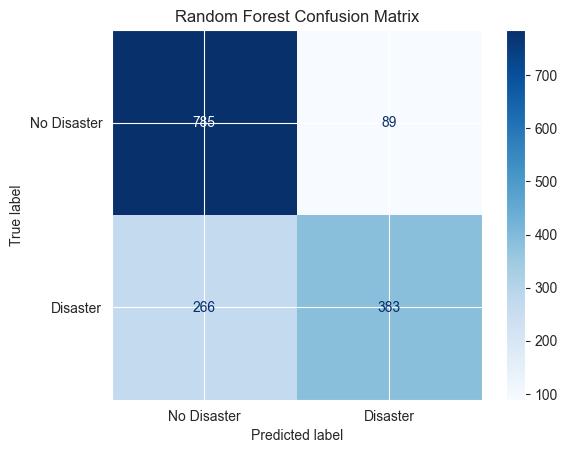

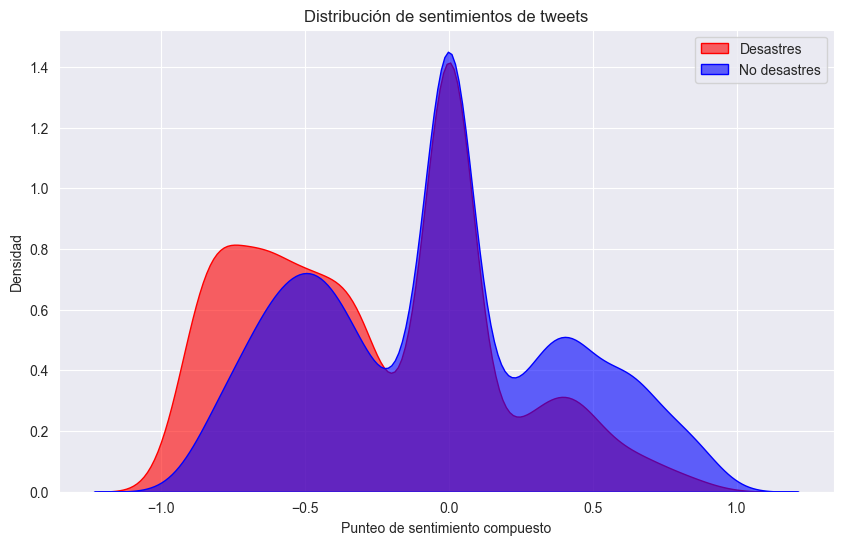

In [16]:
%pip install emoji

# imports
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import emoji

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
## Análisis exploratorio
file_path = "data/train.csv"
data = pd.read_csv(file_path)
data.head()
data.info()
data.describe()
sns.countplot(x='target', data=data)
plt.title('Distribución de tweets')
plt.ylabel('Frecuencia')
plt.xlabel('Tipo de tweet')
plt.show()
data.isnull().sum()
STOP_WORDS = set(stopwords.words('english'))
BANNED_WORDS = ['im', 'one', 'u', 'rt']


def limpiar_texto(texto: str) -> str:
    if not texto:
        return ""

    # Vectorized operations for text cleaning
    texto = texto.lower()
    texto = emoji.replace_emoji(texto, replace='')  # Remove emojis
    texto = re.sub(r'[#@&][\S]+', '', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal using the precomputed stopwords
    tokens = [word for word in word_tokenize(texto) if ((word not in STOP_WORDS) and (word not in BANNED_WORDS))]

    texto_limpio = ' '.join(tokens)
    return texto_limpio


data['clean_text'] = data['text'].apply(limpiar_texto)
data['clean_text'].head()
disaster_tweets = data[data['target'] == 1]['clean_text']
non_disaster_tweets = data[data['target'] == 0]['clean_text']

disaster_words = ' '.join(disaster_tweets)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets de Desastres')
plt.axis('off')
plt.show()
non_disaster_words = ' '.join(non_disaster_tweets)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets No Desastres')
plt.axis('off')
plt.show()
## Limpieza de textos
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


def clean_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens


disaster_tweets_tokens = disaster_tweets.apply(clean_text)
non_disaster_tweets_tokens = non_disaster_tweets.apply(clean_text)
### Palabras comunes
disaster_word_freq = Counter([word for tokens in disaster_tweets_tokens for word in tokens])
non_disaster_word_freq = Counter([word for tokens in non_disaster_tweets_tokens for word in tokens])

common_words = set(disaster_word_freq.keys()).intersection(set(non_disaster_word_freq.keys()))

common_words_freq = {word: (disaster_word_freq[word], non_disaster_word_freq[word]) for word in common_words}

common_words_sorted = sorted(common_words_freq.items(), key=lambda x: x[1][0], reverse=True)

print("Palabras comunes más frecuentes en tweets de desastres y no desastres:")
for word, (freq_disaster, freq_non_disaster) in common_words_sorted[:10]:
    print(f"Palabra: {word}, Frecuencia en Desastres: {freq_disaster}, Frecuencia en No Desastres: {freq_non_disaster}")

import numpy as np

words = [item[0] for item in common_words_sorted[:25]]
disaster_freqs = [item[1][0] for item in common_words_sorted[:25]]
non_disaster_freqs = [item[1][1] for item in common_words_sorted[:25]]

# Plot the common word frequencies
x = np.arange(len(words))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create the bars for both disaster and non-disaster word frequencies
rects1 = ax.bar(x - width / 2, disaster_freqs, width, label='Desastres', color='b')
rects2 = ax.bar(x + width / 2, non_disaster_freqs, width, label='No desastres', color='orange')

# Add labels and title
ax.set_xlabel('Palabras')
ax.set_ylabel('Frecuencia')
ax.set_title('Frecuencia de palabras comunes en tweets')
ax.set_xticks(x)
ax.set_xticklabels(words, rotation=90, ha='right')

# Add a legend
ax.legend()


# Function to label the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Call the autolabel function for both sets of bars
autolabel(rects1)
autolabel(rects2)

# Adjust layout for better fit
fig.tight_layout()

# Show the plot
plt.show()
## Modelo sin incluir sentiment analysis
# Vectorización usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_rf = vectorizer.fit_transform(data['clean_text']).toarray()
y = data['target'].values

# División en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluación del modelo
rf_predictions = rf_model.predict(X_test_rf)
print("Resultados para Random Forest:")
print(classification_report(y_test_rf, rf_predictions))

rf_predictions = rf_model.predict(X_test_rf)

# Generate confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test_rf, rf_predictions)
print("Confusion Matrix for Random Forest:")
print(rf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()
## Modelo con sentiment Analysis
analyzer = SentimentIntensityAnalyzer()


def get_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['pos'], sentiment_scores['compound']


data[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = data['clean_text'].apply(
    lambda x: pd.Series(get_vader_sentiment(x)))
data.head()
data['text_length'] = data['clean_text'].apply(len)
tfidf = TfidfVectorizer(max_features=5000)  # Use the top 1000 words
tfidf_matrix = tfidf.fit_transform(data['clean_text']).toarray()

# Add TF-IDF features to the DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names_out())
df = pd.concat([data.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

X = df.drop(['id', 'keyword', 'location', 'text', 'target', 'clean_text'], axis=1)  # Drop non-feature columns
y = df['target']
y = y.iloc[:, 0]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluación del modelo
clf_predictions = clf.predict(X_test)
print("Resultados para Random Forest:")
print(classification_report(y_test, clf_predictions))
clf_predictions = clf.predict(X_test)

# Generate confusion matrix for Random Forest
clf_cm = confusion_matrix(y_test, clf_predictions)
print("Confusion Matrix for Random Forest:")
print(clf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()
data.head()
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

plt.figure(figsize=(10, 6))

# Plot the density of compound sentiment for disaster and non-disaster tweets
sns.kdeplot(disaster_tweets['compound_sentiment'], label='Desastres', fill=True, color='red', alpha=0.6)
sns.kdeplot(non_disaster_tweets['compound_sentiment'], label='No desastres', fill=True, color='blue', alpha=0.6)

# Add titles and labels
plt.title('Distribución de sentimientos de tweets')
plt.xlabel('Punteo de sentimiento compuesto')
plt.ylabel('Densidad')
plt.legend()

# Show the plot
plt.show()

# Lab 9

2024-10-16 22:31:55.358 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.360 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.362 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.363 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.364 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-16 22:31:55.365 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

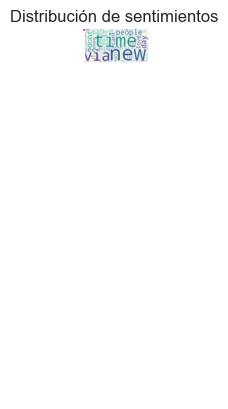

In [17]:
import streamlit as st

# Create Streamlit app structure
st.title("Interactive Disaster Tweet Dashboard")

# Sidebar filters
st.sidebar.title("Tweet Filters")
target_option = st.sidebar.selectbox("Select Tweet Type", ["All", "Disaster", "Non-Disaster"])
sentiment_range = st.sidebar.slider("Sentiment Range (compound score)", -1.0, 1.0, (-1.0, 1.0))

# Filter data based on sidebar options
filtered_data = data.copy()
if target_option == "Disaster":
    filtered_data = filtered_data[filtered_data['target'] == 1]
elif target_option == "Non-Disaster":
    filtered_data = filtered_data[filtered_data['target'] == 0]

# Sentiment analysis filter (already applied in the original code)
filtered_data = filtered_data[(filtered_data['compound_sentiment'] >= sentiment_range[0]) &
                              (filtered_data['compound_sentiment'] <= sentiment_range[1])]

# Visualizations using Streamlit
st.header("Tweet Distribution by Target")
sns.countplot(x='target', data=filtered_data)
plt.title('Distribución de tweets')
plt.ylabel('Frecuencia')
plt.xlabel('Tipo de tweet')
st.pyplot(plt)

# WordCloud for Disaster Tweets
st.header("Word Cloud - Disaster Tweets")
disaster_tweets = ' '.join(filtered_data[filtered_data['target'] == 1]['clean_text'])
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
st.pyplot(plt)

# WordCloud for Non-Disaster Tweets
st.header("Word Cloud - Non-Disaster Tweets")
non_disaster_tweets = ' '.join(filtered_data[filtered_data['target'] == 0]['clean_text'])
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_tweets)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.axis('off')
st.pyplot(plt)

# Sentiment Distribution using KDE Plot
st.header("Sentiment Distribution for Tweets")
sns.kdeplot(filtered_data[filtered_data['target'] == 1]['compound_sentiment'], label='Disaster', fill=True, color='red', alpha=0.6)
sns.kdeplot(filtered_data[filtered_data['target'] == 0]['compound_sentiment'], label='Non-Disaster', fill=True, color='blue', alpha=0.6)
plt.title("Distribución de sentimientos")
plt.xlabel("Punteo de sentimiento compuesto")
plt.ylabel("Densidad")
st.pyplot(plt)